Anggota Kelompok:

Ahmad Syafiq Hartono – 2702317153 

Enrico Cen - 2702309813 

Fidelis Marcelino - 2702312556 

Satrio Halim Abdurrahman - 2702298545 

Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

Preprocessing Data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Data Loading and Preprocessing ===

Preprocessing Statistics:
--------------------------------------------------
Total samples: 2934
Average text length before preprocessing: 147.2 characters
Average text length after preprocessing: 89.2 characters

Class Distribution Before Balancing:


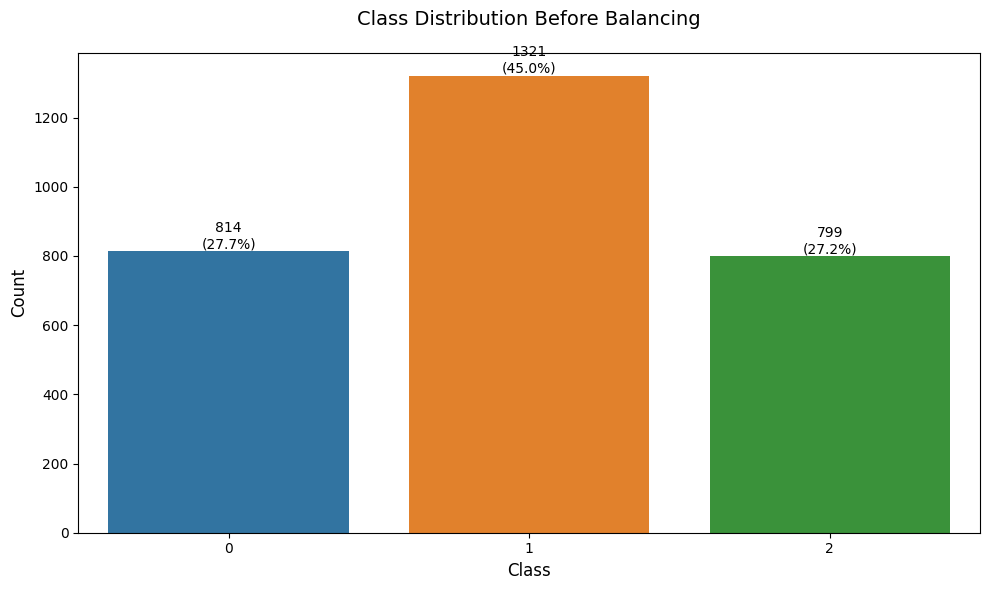

In [2]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    """Detailed text preprocessing"""
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove short tokens
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

def plot_class_distribution(y, title):
    """Plot class distribution with percentages"""
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=y)
    plt.title(title, pad=20, size=14)
    plt.xlabel('Class', size=12)
    plt.ylabel('Count', size=12)
    
    # Calculate percentages
    total = len(y)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(f'{int(p.get_height())}\n({percentage})', 
                   (x, y), 
                   ha='center', 
                   va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix with metrics"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d',
                cmap='viridis',
                square=True,
                cbar=True,
                xticklabels=['0', '1', '2'],
                yticklabels=['0', '1', '2'])
    
    plt.title(title, pad=20, size=14)
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_test, y_score, n_classes):
    """Plot ROC curves for each class"""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess data
print("\n=== Data Loading and Preprocessing ===")
excel_path = "clean_data (1) - Copy.xlsx"
df = pd.read_excel(excel_path)

# Clean and preprocess
df = df.dropna(subset=['text ', 'label'])
df['processed_text'] = df['text '].apply(preprocess_text)

# Display preprocessing statistics
print("\nPreprocessing Statistics:")
print("-" * 50)
print(f"Total samples: {len(df)}")
print(f"Average text length before preprocessing: {df['text '].str.len().mean():.1f} characters")
print(f"Average text length after preprocessing: {df['processed_text'].str.len().mean():.1f} characters")

# Plot original class distribution
print("\nClass Distribution Before Balancing:")
plot_class_distribution(df['label'], 'Class Distribution Before Balancing')

# Prepare features
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text'])
y = df['label']

Balancing & Split Data


Data Split Statistics:
--------------------------------------------------
Training set: 2059 samples (70.2%)
Validation set: 581 samples (19.8%)
Test set: 294 samples (10.0%)

=== Applying SMOTE for Data Balancing ===

Class Distribution After SMOTE:


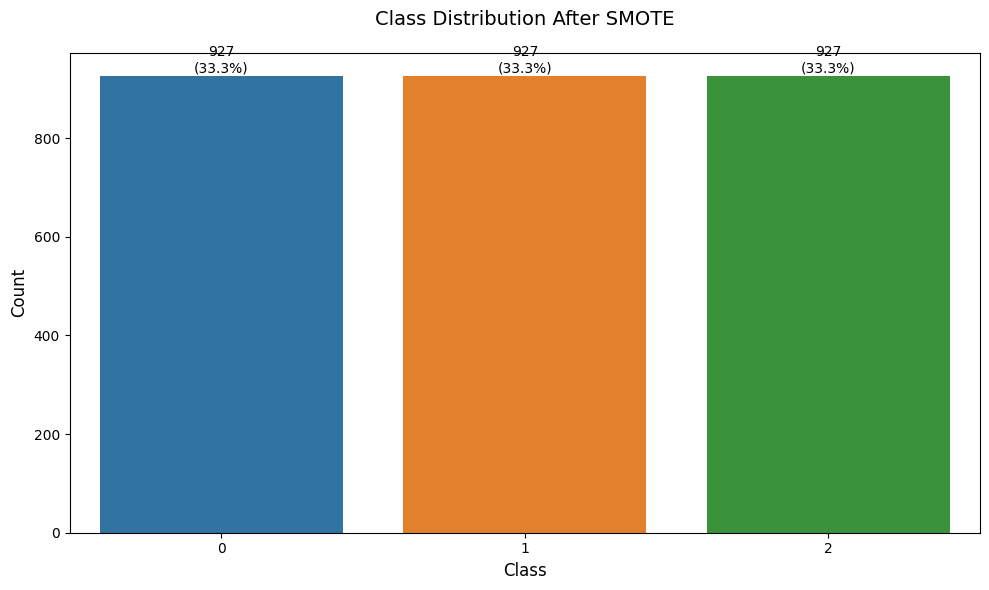

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42, stratify=y_temp)

print("\nData Split Statistics:")
print("-" * 50)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Apply SMOTE
print("\n=== Applying SMOTE for Data Balancing ===")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:")
plot_class_distribution(y_train_balanced, 'Class Distribution After SMOTE')

Cross-Validation

In [4]:
print("\n=== Detailed Cross-validation Results ===")
base_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Get detailed metrics for each fold
cv_results = cross_validate(
    base_model, 
    X_train_balanced, 
    y_train_balanced,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True,
    n_jobs=-1  # Use all CPU cores
)

# Create detailed results table
fold_results = pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train Precision': cv_results['train_precision_macro'],
    'Val Precision': cv_results['test_precision_macro'],
    'Train Recall': cv_results['train_recall_macro'],
    'Val Recall': cv_results['test_recall_macro'],
    'Train F1': cv_results['train_f1_macro'],
    'Val F1': cv_results['test_f1_macro']
})

# Add mean and std rows
mean_row = fold_results.mean().to_frame('Mean').T
std_row = fold_results.std().to_frame('Std').T
fold_results = pd.concat([fold_results, mean_row, std_row])

# Format the table
print("\nDetailed Cross-validation Results:")
print(tabulate(fold_results.round(3), headers='keys', tablefmt='grid', showindex=False))


=== Detailed Cross-validation Results ===

Detailed Cross-validation Results:
+--------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------+----------+
|   Fold |   Train Accuracy |   Val Accuracy |   Train Precision |   Val Precision |   Train Recall |   Val Recall |   Train F1 |   Val F1 |
+========+==================+================+===================+=================+================+==============+============+==========+
|  1     |            0.937 |          0.555 |             0.94  |           0.58  |          0.937 |        0.555 |      0.937 |    0.555 |
+--------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------+----------+
|  2     |            0.935 |          0.563 |             0.939 |           0.579 |          0.935 |        0.563 |      0.935 |    0.564 |
+--------+------------------+----------------+-------------------+---------

Tuning

In [5]:
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1],  # Reduced learning rate options
    'n_estimators': [100],   # Reduced number of estimators
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],      # Added subsample parameter
    'colsample_bytree': [0.8]  # Added column sampling parameter
}

# Create and configure the GridSearchCV with verbose output
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1,  # Use all CPU cores for individual model
        verbosity=0  # Reduce XGBoost verbosity
    ),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,  # Use all CPU cores for parallel grid search
    verbose=2    # Add verbosity to track progress
)

print("\nStarting Grid Search (this may take a few minutes)...")
grid_search.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters:")
print("-" * 50)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {grid_search.best_score_:.3f}")



=== Hyperparameter Tuning ===

Starting Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters:
--------------------------------------------------
colsample_bytree: 0.8
gamma: 0
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 100
subsample: 0.8

Best cross-validation score: 0.607


Evaluation


=== Model Evaluation ===

Training final model...

Training Set Results:
--------------------------------------------------

Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.58      0.89      0.71       571
           1       0.82      0.69      0.75       927
           2       0.87      0.62      0.72       561

    accuracy                           0.73      2059
   macro avg       0.76      0.73      0.73      2059
weighted avg       0.77      0.73      0.73      2059


Confusion Matrix - Training Set:


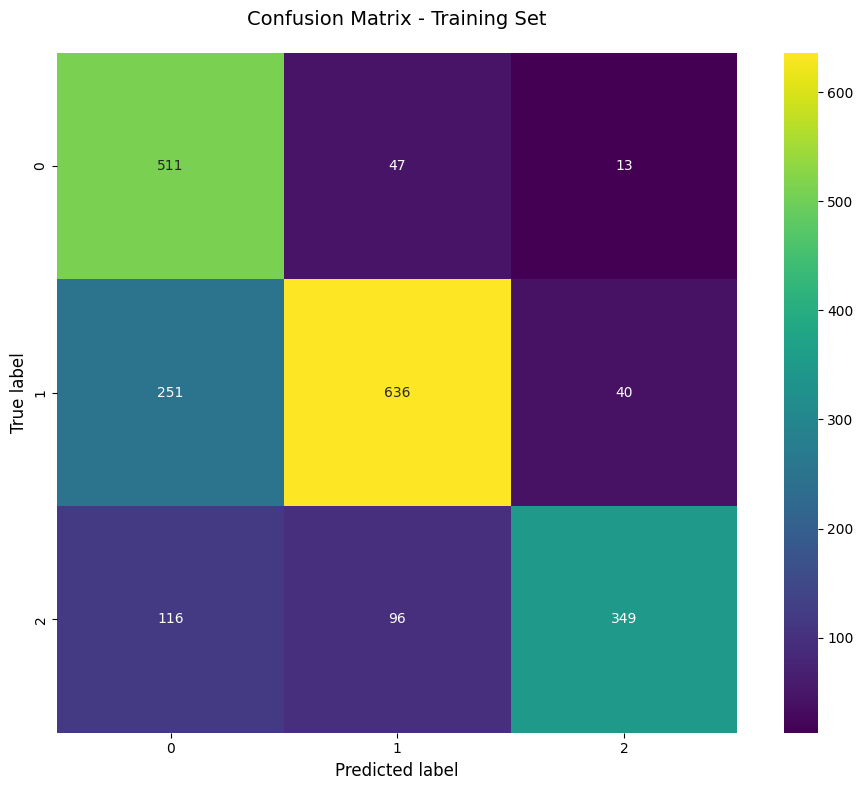


Validation Set Results:
--------------------------------------------------

Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.45      0.66      0.53       161
           1       0.58      0.47      0.52       262
           2       0.56      0.45      0.50       158

    accuracy                           0.52       581
   macro avg       0.53      0.53      0.52       581
weighted avg       0.54      0.52      0.52       581


Confusion Matrix - Validation Set:


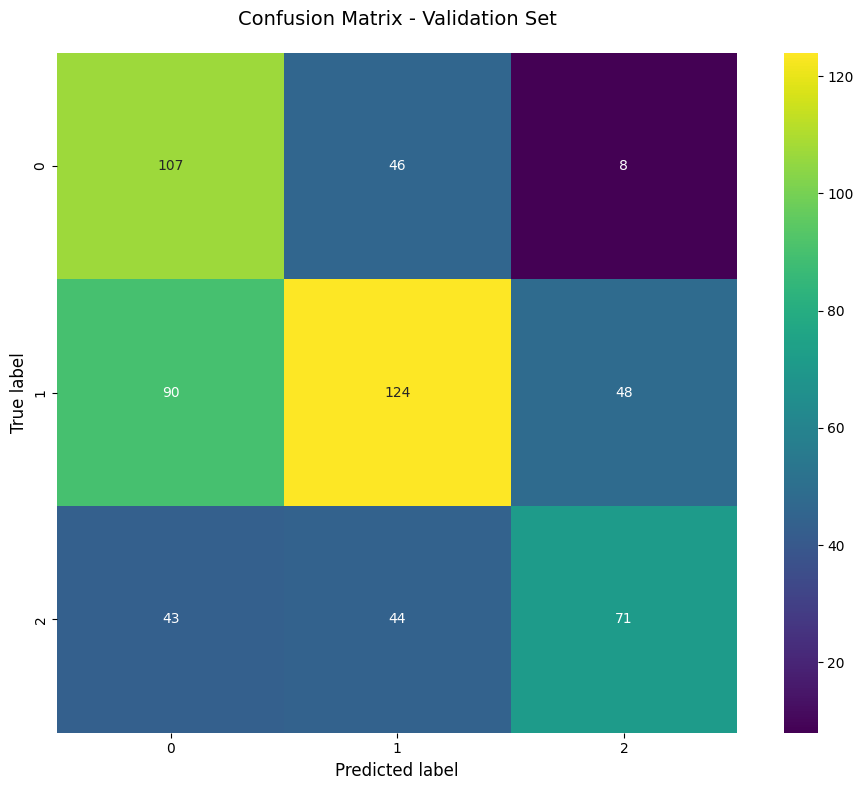


Test Set Results:
--------------------------------------------------

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.40      0.61      0.48        82
           1       0.52      0.43      0.47       132
           2       0.55      0.40      0.46        80

    accuracy                           0.47       294
   macro avg       0.49      0.48      0.47       294
weighted avg       0.49      0.47      0.47       294


Confusion Matrix - Test Set:


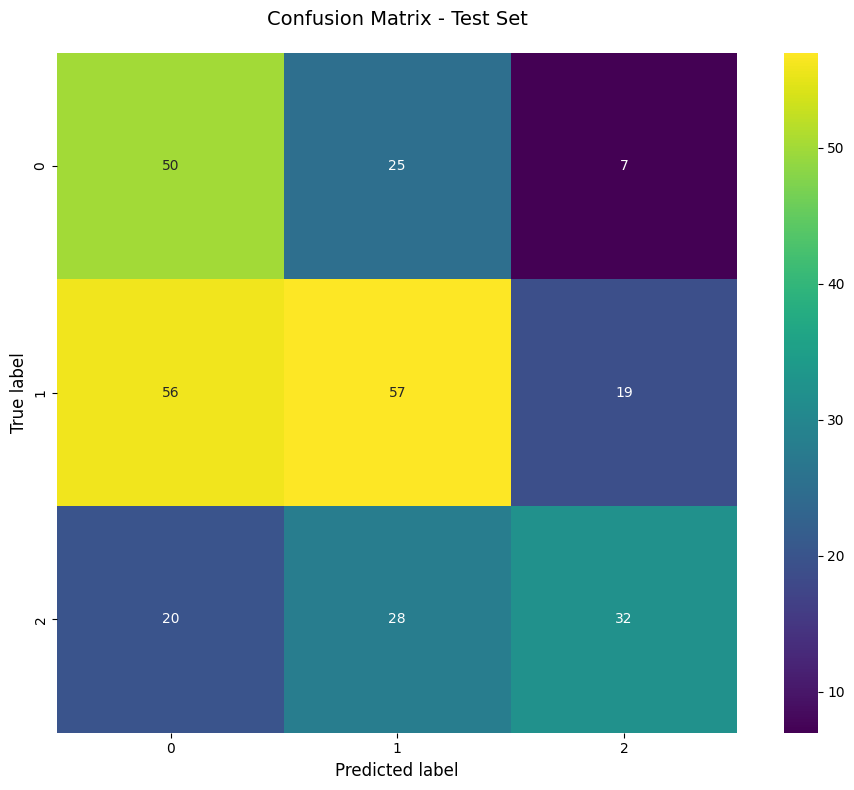


=== ROC Curves ===


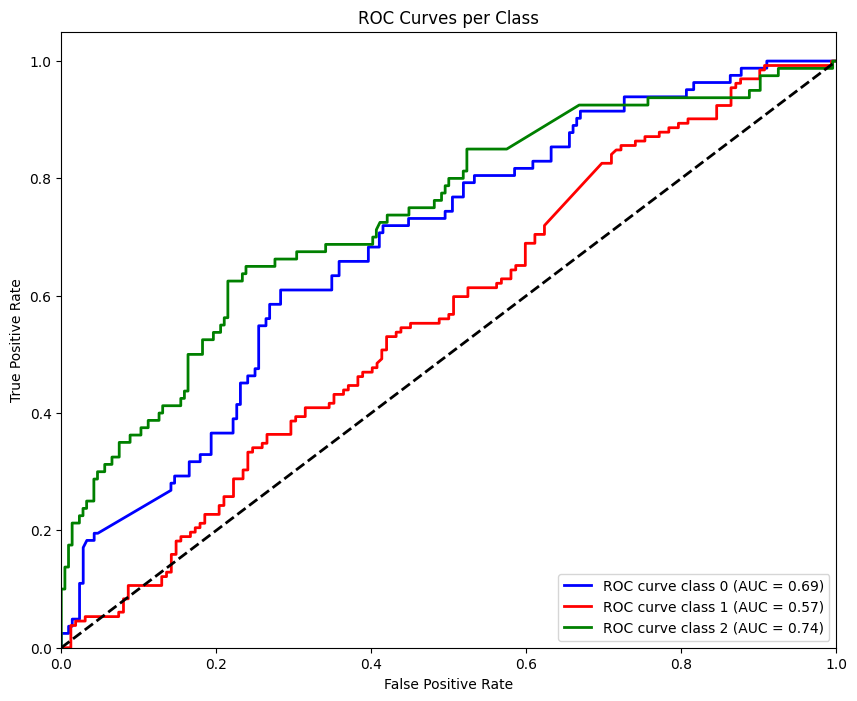


=== Feature Importance Analysis ===


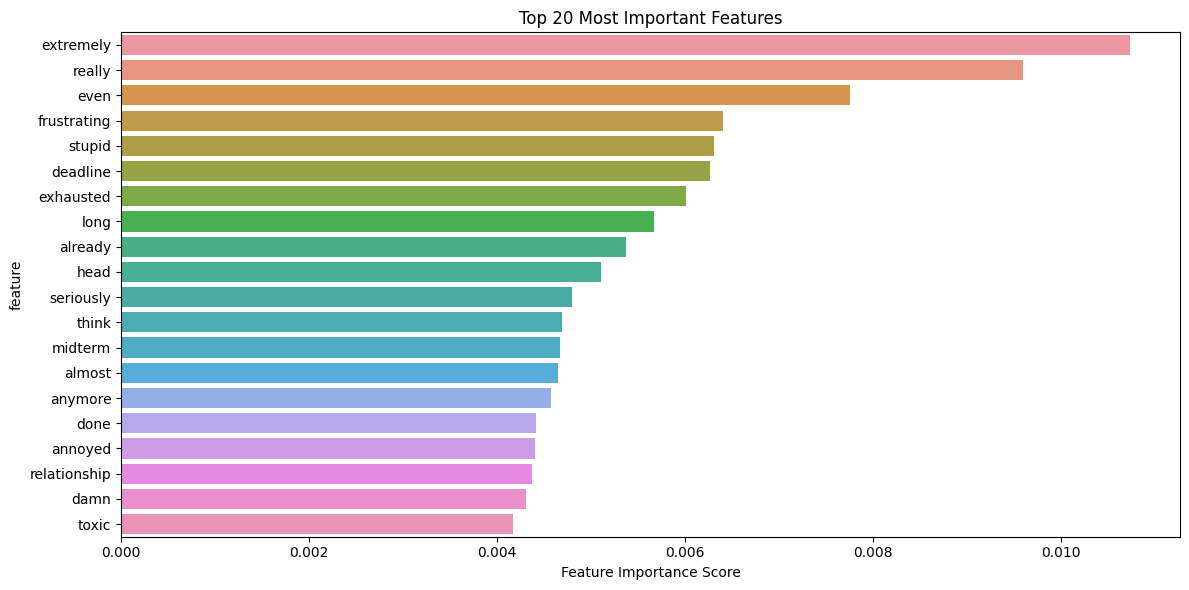


=== Saving Results ===

Detailed predictions have been saved to 'detailed_classification_results.csv'


In [6]:
print("\n=== Model Evaluation ===")
final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    objective='multi:softprob',
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbosity=0
)

print("\nTraining final model...")
final_model.fit(
    X_train_balanced,
    y_train_balanced,
    verbose=False
)

# Evaluate on all sets
sets = {
    'Training': (X_train, y_train),
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test)
}

for set_name, (X_set, y_set) in sets.items():
    print(f"\n{set_name} Set Results:")
    print("-" * 50)
    predictions = final_model.predict(X_set)
    
    print(f"\nClassification Report - {set_name} Set:")
    print(classification_report(y_set, predictions))
    
    print(f"\nConfusion Matrix - {set_name} Set:")
    plot_confusion_matrix(y_set, predictions, f'Confusion Matrix - {set_name} Set')

# ROC curves for test set
print("\n=== ROC Curves ===")
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = final_model.predict_proba(X_test)
plot_roc_curves(y_test_bin, y_score, n_classes=3)

# Feature importance visualization
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

# Save results
print("\n=== Saving Results ===")
predictions_df = pd.DataFrame({
    'Text': df.loc[y_test.index, 'text '],
    'True_Label': y_test,
    'Predicted_Label': final_model.predict(X_test),
    'Probability_Class_0': y_score[:, 0],
    'Probability_Class_1': y_score[:, 1],
    'Probability_Class_2': y_score[:, 2]
})
predictions_df.to_csv('detailed_classification_results.csv', index=False)
print("\nDetailed predictions have been saved to 'detailed_classification_results.csv'") 